<a href="https://colab.research.google.com/github/hossein20s/aBinaryClassification/blob/master/Tempus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Definition
Check it out from https://drive.google.com/file/d/0B2N190SEI1grNXRxRjN5NWdkWWVHSzZyNWN5bWJNNUo3T3BF/view?usp=drivesdk


# Initialize
My script to connect colab to Google drive and bring some python library

In [0]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/data" data

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
ln: failed to create symbolic link 'data/data': Function not implemented


# Data Preparation
unzip, Unspact the file in OS to get an idea that how many line does it have and how does it look like

In [0]:
!gunzip data/DScasestudy.txt.gz
!wc -l data/DScasestudy.txt

gzip: data/DScasestudy.txt.gz: No such file or directory
531 data/DScasestudy.txt


Conver it to Pandas Dataframe and check it’s shape

In [0]:
DATA_FILE = 'data/DScasestudy.txt'
import pandas as pd

data = pd.read_csv(DATA_FILE, sep="\t")
print(data.shape)

(530, 16563)


*  Take a look at the first couple of lines 
*  If it has any missing data: *It didn’t*
*  Some statistics on the data: *Sparse data with 0 or 1 values (most probably)*




In [0]:
print(data.iloc[1:3,0:4])
print(data.isnull().values.any())
print(data.describe())

   response  V1  V2  V3
1         1   0   0   0
2         1   0   0   0
False
         response          V1          V2  ...      V16560  V16561      V16562
count  530.000000  530.000000  530.000000  ...  530.000000   530.0  530.000000
mean     0.232075    0.009434    0.009434  ...    0.003774     0.0    0.447170
std      0.422556    0.096761    0.096761  ...    0.061371     0.0    0.497671
min      0.000000    0.000000    0.000000  ...    0.000000     0.0    0.000000
25%      0.000000    0.000000    0.000000  ...    0.000000     0.0    0.000000
50%      0.000000    0.000000    0.000000  ...    0.000000     0.0    0.000000
75%      0.000000    0.000000    0.000000  ...    0.000000     0.0    1.000000
max      1.000000    1.000000    1.000000  ...    1.000000     0.0    1.000000

[8 rows x 16563 columns]


Lets plot one case and couple of feature to see if any pattern can be detected by eye. There is an imbalance between response 1 and 0 but it is not much. Looks like other values are all 0 or 1

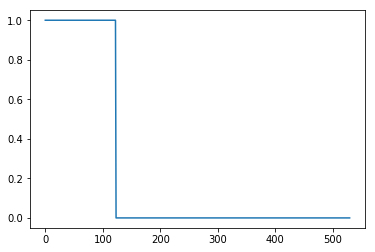

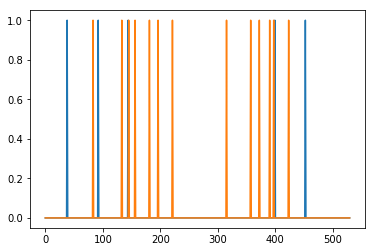

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(data.iloc[:,0])
plt.show()
plt.plot(data.iloc[:,2])
plt.plot(data.iloc[:,16000])

Probably many columns are all 0

In [0]:
data.columns[(data == 0).all()]

Index(['V4', 'V9', 'V10', 'V12', 'V14', 'V15', 'V16', 'V19', 'V21', 'V37',
       ...
       'V16530', 'V16531', 'V16533', 'V16536', 'V16537', 'V16538', 'V16554',
       'V16555', 'V16559', 'V16561'],
      dtype='object', length=5492)

# Data Reduction

Using PCA we can reduce the number of feaures, preferrably to the same size of data (around 500).

First separate Labels from Features

In [0]:
labels = data.iloc[:,0]
features = data.iloc[:,1:]
print(features.values.shape)

(530, 16562)


Even though the data bounded to 0 and 1. We apply MinMax for the sake of reusing it for future data

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=[0, 1])
rescaled = scaler.fit_transform(features)

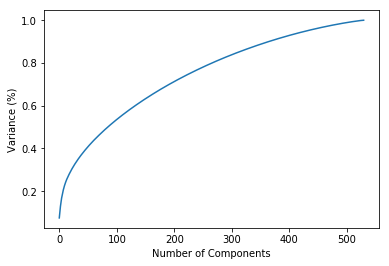

In [0]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

#Fitting the PCA algorithm with our Data
pca = PCA().fit(rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.show()

We can pick only 200 components

In [0]:
pca = PCA(n_components=200)
dataset = pca.fit_transform(rescaled)
print(dataset.shape)

(530, 200)


# Data Preparation

In [0]:
from sklearn.model_selection import train_test_split
random_state = 42

train_unscaled,test_unscaled,y_train,y_test = train_test_split(dataset, labels, 
                        test_size=0.2, shuffle=True,
                         random_state=random_state)

Rescale the data and set it around 0 (We need it for SVM)

In [0]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(train_unscaled)
X_test = sc.transform(test_unscaled)


# Model Selection
This is the Binary Classification
Often the best model is RandomForest so lets start with it

In [0]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=20, random_state=random_state)


In [0]:
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

In [0]:
print(rfc_pred.shape)
print(rfc_pred)

(106,)
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Model Evaluation

For Classification AUC_ROC is the right metric to evaluate.
Lets first check the confusion matrix

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))
print(accuracy_score(y_test, rfc_pred))

[[73  1]
 [29  3]]
              precision    recall  f1-score   support

           0       0.72      0.99      0.83        74
           1       0.75      0.09      0.17        32

    accuracy                           0.72       106
   macro avg       0.73      0.54      0.50       106
weighted avg       0.73      0.72      0.63       106

0.7169811320754716


This is a classification so the real measurement of model is Aread Under Curve of ROC Curve

In [0]:
import numpy as np
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, rfc_pred)

0.5401182432432432

# Another Model (SVM)

In [0]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')

In [0]:
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
print(confusion_matrix(y_test,svc_pred))
print(classification_report(y_test,svc_pred))
print(accuracy_score(y_test, svc_pred))
print(roc_auc_score(y_test, svc_pred))

[[65  9]
 [17 15]]
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        74
           1       0.62      0.47      0.54        32

    accuracy                           0.75       106
   macro avg       0.71      0.67      0.68       106
weighted avg       0.74      0.75      0.74       106

0.7547169811320755
0.6735641891891891


# Other models 

We can try Logistic Regression or Naive Bayes and set the threshold of 0.5. However most probabaly SVM does a better job

In [0]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

# Neural Network model

In [0]:
from keras.models import Sequential
from keras.layers import Dense

def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(30, input_dim=200, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=10, batch_size=10, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))